# F1 Setup Notebook

This notebook is here to use ML to determine optimal setups for the F1 games. It is based on the data from the F1 games via telemetry, and uses CSV's generated by the SIM Racing Telemetry app. 

## Understanding Track Types
Generally speaking, there are 3 types of tracks in F1:
- High Downforce
- Balanced
- Power Tracks

High Downforce tracks are tracks like Monaco, Singapore, and Hungary. These tracks have a lot of corners, and require a lot of downforce to get around the track quickly. Power Tracks are the opposite, which require a higher top speed due to fast corners and long straights, like Monza, Canada, and Baku. Balanced tracks are a mix of both, like Silverstone, Spa, and Suzuka. There is also another way to categorize the tracks, which is by Tyre Wear. Some tracks have high tyre wear, like Silverstone, while others have low tyre wear, like Monza.

To begin, we will create a DF that contains all the tracks, and their respective types.

In [1]:
%pip install --upgrade pip
%pip install scikit-learn

import pandas as pd
import matplotlib.pyplot as plt
import sklearn as skl
import numpy as np

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
track_df = pd.read_csv('data/track_categories.csv')
print(track_df)

            Track Track Performance Tyre Wear
0         Bahrain         Top Speed      High
1    Saudi Arabia         Top Speed      High
2       Australia          Balanced    Medium
3      Azerbaijan         Top Speed    Medium
4           Miami          Balanced    Medium
5           Imola         Top Speed       Low
6          Monaco         Downforce    Medium
7           Spain          Balanced       Low
8          Canada         Top Speed       Low
9         Austria         Top Speed       Low
10  Great Britain          Balanced       Low
11        Hungary         Downforce       Low
12        Belgium         Top Speed       Low
13    Netherlands         Downforce       Low
14          Monza         Top Speed    Medium
15      Singapore         Downforce    Medium
16          Japan         Top Speed       Low
17          Qatar         Top Speed    Medium
18          Texas         Top Speed    Medium
19         Mexico         Downforce      High
20         Brazil         Top Spee

## Parsing the Data

Our next step is now going to be to understand the data we have. For this experiment, we will be doing multiple runs on the same track using fresh soft tyres for each run. Let's import the data and combine them into a single dataframe. Our initial experiment will be in Spain, given that it is a common test track, and we used the Red Bull on Equal Performance.

In [3]:
fp1_df = pd.read_csv('data/spain_gp_fp1.csv', sep='\t')
fp2_df = pd.read_csv('data/spain_gp_fp2.csv', sep='\t')
fp2_2_df = pd.read_csv('data/spain_gp_fp2_2.csv', sep='\t')

Now we do have an initial issue: 2 data files means that our lap nums are reset. For this, we will be using some python to update the lap numbers in the fp2 data to be unqiue from the fp1 data. In order to do this correctly, we will first filter out any laps that are not valid, and then we will update the lap numbers. This function below will help us do that.

In [4]:
def filterLaps(fp_df) -> pd.DataFrame:
    maxBinIndex = fp_df['binIndex'].max()
    validLaps = fp_df[fp_df['binIndex'] == maxBinIndex][fp_df['lap_time_invalid'] > -1].reset_index(drop=True)
    return validLaps

In [5]:
fp1_validlaps = filterLaps(fp1_df)
fp2_validlaps = filterLaps(fp2_df)
fp2_2_validlaps = filterLaps(fp2_2_df)
fp1_maxlap = max(fp1_validlaps['lapNum'].unique())
fp2_validlaps['lapNum'] = fp2_validlaps['lapNum'] + fp1_maxlap + 1
fp2_maxlap = max(fp2_validlaps['lapNum'].unique())
fp2_2_validlaps['lapNum'] = fp2_2_validlaps['lapNum'] + fp2_maxlap + 1
print(fp2_2_validlaps)

             carId    trackId  trackLength  lapIndex  lapNum  lapFlag  \
0  Red Bull Racing  Catalunya         4664         0      15        0   
1  Red Bull Racing  Catalunya         4664         1      16        0   
2  Red Bull Racing  Catalunya         4664         2      17        0   
3  Red Bull Racing  Catalunya         4664         3      18        0   
4  Red Bull Racing  Catalunya         4664         4      19        0   

   binIndex  validBin  lap_number  lap_distance  ...  gear_box_damage  \
0      4663         1           0       4663.40  ...                0   
1      4663         1           1       4663.77  ...                0   
2      4663         1           2       4663.64  ...                0   
3      4663         1           3       4663.32  ...                0   
4      4663         1           4       4664.00  ...                0   

   engine_damage  mguh_damage  es_damage  ce_damage  ice_damage  mguk_damage  \
0              0         0.00       0.00  

/var/folders/7v/5sz92nkn6s13fvy6c8bz7_sm0000gn/T/ipykernel_99423/537009178.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  validLaps = fp_df[fp_df['binIndex'] == maxBinIndex][fp_df['lap_time_invalid'] > -1].reset_index(drop=True)


Finally, we can combine the data into a single dataframe, and tag it with the corresponding tyre wear and track type.

In [6]:
fp_df = pd.concat([fp1_validlaps, fp2_validlaps, fp2_2_validlaps], ignore_index=True)
fp_df['tyre_wear_type'] = track_df[track_df['Track'] == 'Spain']['Tyre Wear'].values[0]
fp_df['track_type'] = track_df[track_df['Track'] == 'Spain']['Track Performance'].values[0]
print(fp_df)

              carId    trackId  trackLength  lapIndex  lapNum  lapFlag  \
0   Red Bull Racing  Catalunya         4664         0       0        0   
1   Red Bull Racing  Catalunya         4664         1       1        0   
2   Red Bull Racing  Catalunya         4664         2       2        0   
3   Red Bull Racing  Catalunya         4664         3       3        0   
4   Red Bull Racing  Catalunya         4664         4       4        0   
5   Red Bull Racing  Catalunya         4664         5       5        0   
6   Red Bull Racing  Catalunya         4664         6       6        0   
7   Red Bull Racing  Catalunya         4664         7       7        0   
8   Red Bull Racing  Catalunya         4664         8       8        0   
9   Red Bull Racing  Catalunya         4664         9       9        0   
10  Red Bull Racing  Catalunya         4664         0      10        0   
11  Red Bull Racing  Catalunya         4664         1      11        0   
12  Red Bull Racing  Catalunya        

## Showing the Laps

This next section will show us a breakdown of the laps, along with the fastest lap. This will help us understand the data we are working with.

In [7]:
def highlight_min(x):
   min_val = x.min()
   return ['background-color: purple' if val == min_val else '' for val in x]

fp_df[['lapNum', 'lap_time']].style.apply(highlight_min, axis=0, subset=['lap_time'])

,lapNum,lap_time
0,0,79.168000
1,1,77.436000
2,2,78.212000
3,3,78.426000
4,4,78.327000
5,5,76.995000
6,6,76.481000
7,7,76.984000
8,8,76.901000
9,9,77.430000


Lets also show the summary statistics for the laps, to see how they compare.

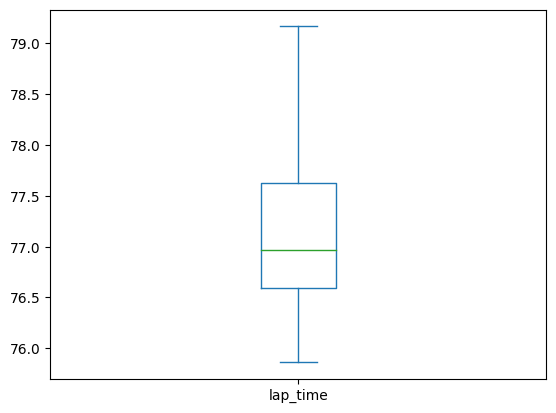

In [8]:
fp_df['lap_time'].describe()
fp_df.plot.box(y='lap_time')

plt.show()

## Showing the Setup

Now lets show the setup we used for each lap.

In [9]:
# Setup Headers
setupHeaders = [
    'lapNum',
    'Front Wing Setup', 
    'Rear Wing Setup', 
    'On Throttle Differential', 
    'Off Throttle Differential', 
    'Front Camber', 
    'Rear Camber', 
    'Front Toe', 
    'Rear Toe',
    'Front Suspension',
    'Rear Suspension',
    'Front Anti-Roll Bar',
    'Rear Anti-Roll Bar',
    'Front Ride Height',
    'Rear Ride Height',
    'Brake Pressure',
    'Brake Bias',
    'Front Left Tyre Pressure',
    'Front Right Tyre Pressure',
    'Rear Left Tyre Pressure',
    'Rear Right Tyre Pressure',
    'Lap Time'
]

setupColumnRename = {
    'wing_setup_0': 'Front Wing Setup', 
    'wing_setup_1': 'Rear Wing Setup', 
    'susp_spring_setup_0': 'Front Suspension',
    'susp_spring_setup_2': 'Rear Suspension',
    'arb_setup_0': 'Front Anti-Roll Bar',
    'arb_setup_1': 'Rear Anti-Roll Bar',
    'susp_height_setup_0': 'Front Ride Height',
    'susp_height_setup_2': 'Rear Ride Height',
    'lap_time': 'Lap Time'
}

# camber map
frontCamberMap = {
    -0.0436332: -2.5, 
    -0.0523599: -3.0,
    -0.0541052: -3.1,
    -0.0558505: -3.2,
}

rearCamberMap = {
    -0.0261799: -1.5,
    -0.0174533: -1.0,
    -0.0279253: -1.6,
    -0.0296706: -1.7,
}

# toe map
frontToeMap = {
    0.000872665: 0.05,
    0: 0
}

rearToeMap = {
    0.00436332: 0.25,
    0.00174533: 0.1
}

# Tyre Pressure Map
tyrePressureMap = {
    156511: 22.7,
    155132: 22.5,
    153064: 22.2,
    139964: 20.3,
    151685: 22.0,
    137895: 20.0,
}

# Visual Compound map
visualCompoundMap = {
    16: 'Soft',
    17: 'Medium',
    18: 'Hard',
    7: 'Intermediate',
    8: 'Wet',
}

# Actual Compound Map
actualCompoundMap = {
    16: 'C5',
    17: 'C4',
    18: 'C3',
    19: 'C2',
    20: 'C1',
    21: 'C0',
    7: 'inter',
    8: 'wet',
}

setup_df = fp_df.rename(columns=setupColumnRename)
setup_df['On Throttle Differential'] = setup_df['diff_onThrottle_setup'] * 100
setup_df['Off Throttle Differential'] = setup_df['diff_offThrottle_setup'] * 100
setup_df['Front Camber'] = setup_df['camber_setup_0'].map(frontCamberMap)
setup_df['Rear Camber'] = setup_df['camber_setup_2'].map(rearCamberMap)
setup_df['Front Toe'] = setup_df['toe_setup_0'].map(frontToeMap)
setup_df['Rear Toe'] = setup_df['toe_setup_2'].map(rearToeMap)
setup_df['Brake Pressure'] = setup_df['brake_press_setup'] * 100
setup_df['Brake Bias'] = setup_df['brake_bias_setup'] * 100
setup_df['Front Left Tyre Pressure'] = setup_df['tyre_press_setup_0'].map(tyrePressureMap)
setup_df['Front Right Tyre Pressure'] = setup_df['tyre_press_setup_1'].map(tyrePressureMap)
setup_df['Rear Left Tyre Pressure'] = setup_df['tyre_press_setup_2'].map(tyrePressureMap)
setup_df['Rear Right Tyre Pressure'] = setup_df['tyre_press_setup_3'].map(tyrePressureMap)
setup_df[setupHeaders].transpose()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
lapNum,0.000,1.000,2.000,3.000,4.000,5.000,6.000,7.000,8.000,9.00,10.000,11.000,12.000,13.000,14.000,15.00,16.000,17.000,18.000,19.000
Front Wing Setup,25.000,25.000,25.000,25.000,25.000,36.000,36.000,36.000,36.000,36.00,45.000,45.000,45.000,45.000,45.000,39.00,39.000,39.000,39.000,39.000
Rear Wing Setup,27.000,27.000,27.000,27.000,27.000,36.000,36.000,36.000,36.000,36.00,45.000,45.000,45.000,45.000,45.000,40.00,40.000,40.000,40.000,40.000
On Throttle Differential,65.000,65.000,65.000,65.000,65.000,65.000,65.000,65.000,65.000,65.00,70.000,70.000,70.000,70.000,70.000,65.00,65.000,65.000,65.000,65.000
Off Throttle Differential,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.000,55.00,55.000,55.000,55.000,55.000,55.000,55.00,55.000,55.000,55.000,55.000
Front Camber,-3.000,-3.000,-3.000,-3.000,-3.000,-3.100,-3.100,-3.100,-3.100,-3.10,-3.200,-3.200,-3.200,-3.200,-3.200,-3.10,-3.100,-3.100,-3.100,-3.100
Rear Camber,-1.500,-1.500,-1.500,-1.500,-1.500,-1.600,-1.600,-1.600,-1.600,-1.60,-1.700,-1.700,-1.700,-1.700,-1.700,-1.60,-1.600,-1.600,-1.600,-1.600
Front Toe,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.050,0.05,0.050,0.050,0.050,0.050,0.050,0.05,0.050,0.050,0.050,0.050
Rear Toe,0.250,0.250,0.250,0.250,0.250,0.250,0.250,0.250,0.250,0.25,0.250,0.250,0.250,0.250,0.250,0.25,0.250,0.250,0.250,0.250
Front Suspension,40.000,40.000,40.000,40.000,40.000,41.000,41.000,41.000,41.000,41.00,41.000,41.000,41.000,41.000,41.000,41.00,41.000,41.000,41.000,41.000


As shown above, you can see we have 3 unique setups: 0-4, 5-9, 10-14. We will now use this data to plot the setup against the lap time, to see if there is any correlation between the setup and the lap time, broken down by the key changes. Note that not all the values change (i.e brake pressure), so we won't be graphing those. 

### Aerodynamics

Lets start by looking at the aerodynamics and seeing what we have.

[38]
          2
0.009155 x - 0.7046 x + 90.23


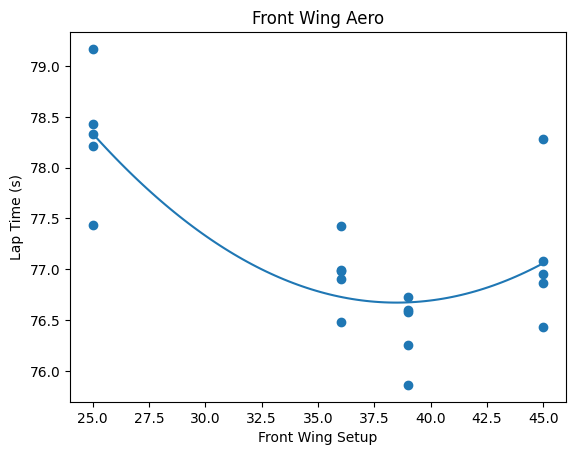

In [14]:
aero_df = setup_df[['Front Wing Setup', 'Lap Time', 'Rear Wing Setup']]
front_wing = aero_df['Front Wing Setup']
back_wing = aero_df['Rear Wing Setup']
lap_time = aero_df['Lap Time']

front_wing_plot = plt.scatter(front_wing, lap_time)
front_wing_model = np.poly1d(np.polyfit(front_wing, lap_time, 2))
myline = np.linspace(front_wing.min(), front_wing.max(), 100)
plt.plot(myline, front_wing_model(myline))
front_aero_mins =  list(map(round, front_wing_model.deriv().r))
print(front_aero_mins)
print(front_wing_model)
plt.title('Front Wing Aero')
plt.xlabel('Front Wing Setup')
plt.ylabel('Lap Time (s)')
plt.show()


[39]


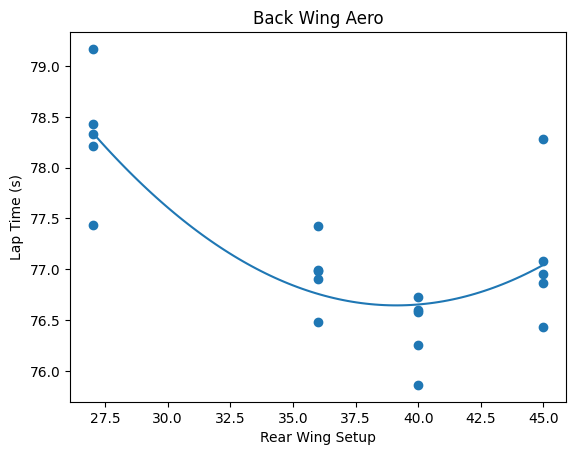

In [11]:
back_wing_plot = plt.scatter(back_wing, lap_time)
back_wing_model = np.poly1d(np.polyfit(back_wing, lap_time, 2))
myline = np.linspace(back_wing.min(), back_wing.max(), 100)
plt.plot(myline, back_wing_model(myline))
back_aero_mins =  list(map(round, back_wing_model.deriv().r))
print(back_aero_mins)
plt.title('Back Wing Aero')
plt.xlabel('Rear Wing Setup')
plt.ylabel('Lap Time (s)')
plt.show()

## Camber 

[-3.1]


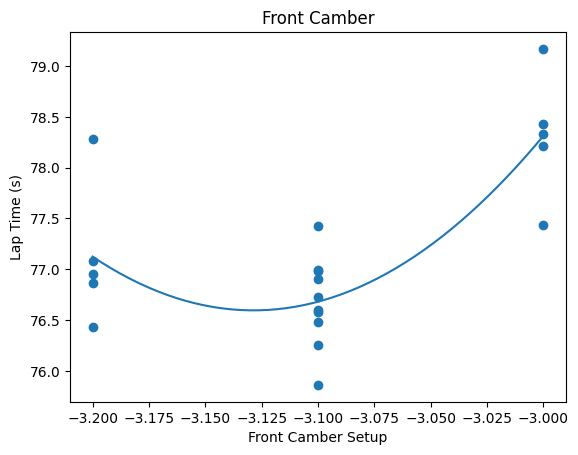

In [12]:
camber_toe_df = setup_df[['Front Camber', 'Rear Camber', 'Front Toe', 'Rear Toe', 'Lap Time']]
front_camber = camber_toe_df['Front Camber']
rear_camber = camber_toe_df['Rear Camber']
lap_time = camber_toe_df['Lap Time']

plt.scatter(front_camber, lap_time)
front_camber_model = np.poly1d(np.polyfit(front_camber, lap_time, 2))
myline = np.linspace(front_camber.min(), front_camber.max())
plt.plot(myline, front_camber_model(myline))
front_camber_mins =  list(map(lambda x: round(x, 1), front_camber_model.deriv().r))
print(front_camber_mins)
plt.title('Front Camber')
plt.xlabel('Front Camber Setup')
plt.ylabel('Lap Time (s)')
plt.show()

[-1.6]


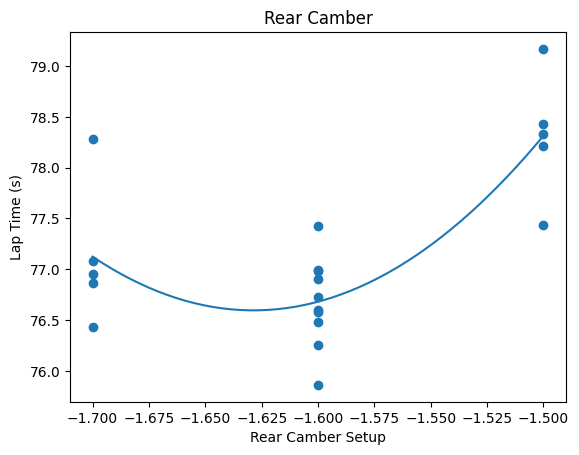

In [13]:
plt.scatter(rear_camber, lap_time)
rear_camber_model = np.poly1d(np.polyfit(rear_camber, lap_time, 2))
myline = np.linspace(rear_camber.min(), rear_camber.max())
plt.plot(myline, rear_camber_model(myline))
rear_camber_min =  list(map(lambda x: round(x, 1), rear_camber_model.deriv().r))
print(rear_camber_min)
plt.title('Rear Camber')
plt.xlabel('Rear Camber Setup')
plt.ylabel('Lap Time (s)')
plt.show()